In [546]:
import folium
from folium import Marker
from folium.plugins import MarkerCluster

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager,rc
import folium

import random

font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)
plt.rcParams['axes.unicode_minus'] = False

## 주요절차

# 데이터분석 적용 실습 템플릿

## 데이터 수집

In [483]:
# 데이터 소스를 확보하세요
df = pd.read_csv('data/충청북도 충주시_빈집현황_20250630.csv', encoding='cp949')
df.head()

,시도명,시군구명,읍면동명,도로명주소,위도,경도,주택유형,구조유형,건축연도,빈집등급,데이터 기준일
0,충청북도,충주시,성내동,"충청북도 충주시 성내길 8-2, (성내동)",36.972572,127.935176,단독,일반목구조,1945.0,3등급,2025-06-30
1,충청북도,충주시,성내동,"충청북도 충주시 성내길 14-5, (성내동)",36.972158,127.935727,단독,일반목구조,1945.0,1등급,2025-06-30
2,충청북도,충주시,성내동,"충청북도 충주시 중앙로 121-1, (성내동)",36.971510,127.936851,그 외,벽돌구조,1970.0,1등급,2025-06-30
3,충청북도,충주시,성내동,"충청북도 충주시 형설로 175-2, (성내동)",36.969717,127.937739,단독,일반목구조,1945.0,2등급,2025-06-30
4,충청북도,충주시,성남동,"충청북도 충주시 성남5길 26-8, (성남동)",36.967932,127.937752,단독,일반목구조,1935.0,2등급,2025-06-30


충청북도 충주시 관내의 빈집 현황을 정리한 데이터로, 방치된 주택에 대한 위치 및 기본 건축정보를 제공합니다.
시도명, 시군구명, 읍면동명, 도로명주소, 위도·경도 좌표, 주택유형, 구조유형, 건축연도, 빈집등급, 기준일자 등의 항목으로 구성되어 있습니다.

빈집은 장기간 거주 또는 사용되지 않은 상태의 주택으로, 「빈집 및 소규모주택 정비에 관한 특례법」에 따라 조사·분류됩니다.

빈집등급은 외관, 안전성, 사용 가능성 등을 종합 평가하여 등급(1~4등급)으로 분류한 것이며, 정비사업 또는 활용 우선순위에 활용됩니다.

주택유형은 단독·다가구 등으로, 구조유형은 목조·벽돌조·철근콘크리트 등 건축물 형태를 나타냅니다.

위도·경도는 현장 위치 확인 및 지도 기반 활용을 위한 정보로, 도시재생계획 수립이나 주거복지 정책 분석에 활용될 수 있습니다.

## 1. 초기데이터 분석

### 1-2. 데이터 기초정보 확인

In [486]:
df.columns

Index(['시도명', '시군구명', '읍면동명', '도로명주소', '위도', '경도', '주택유형', '구조유형', '건축연도',
       '빈집등급', '데이터 기준일'],
      dtype='object')

## 2. 데이터 정제

In [488]:
df2 = df[['읍면동명', '주택유형', '건축연도', '구조유형', '위도', '경도', '빈집등급']]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   읍면동명    399 non-null    object 
 1   주택유형    399 non-null    object 
 2   건축연도    331 non-null    float64
 3   구조유형    399 non-null    object 
 4   위도      399 non-null    float64
 5   경도      399 non-null    float64
 6   빈집등급    399 non-null    object 
dtypes: float64(3), object(4)
memory usage: 21.9+ KB


In [489]:
df2.dropna(subset='건축연도', inplace=True) # ['건축연도'] 컬럼의 결측치 제거
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331 entries, 0 to 398
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   읍면동명    331 non-null    object 
 1   주택유형    331 non-null    object 
 2   건축연도    331 non-null    float64
 3   구조유형    331 non-null    object 
 4   위도      331 non-null    float64
 5   경도      331 non-null    float64
 6   빈집등급    331 non-null    object 
dtypes: float64(3), object(4)
memory usage: 20.7+ KB


/var/folders/23/qgt2mjpx7sb3m0p8nyjbzxcm0000gn/T/ipykernel_30648/207966131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(subset='건축연도', inplace=True) # ['건축연도'] 컬럼의 결측치 제거


In [491]:
# 건축연도를 범주화
def arch_year(year): # 규모구분
    if year < 1935:
        return '90년이상'
    elif 1935 <= year < 1955:
        return '70년이상'
    elif 1955 <= year < 1975:
        return '50년이상'
    elif 1975 <= year < 1995:
        return '30년이상'
    else:
        return '10년이상'

df2['건축물_연식'] = df2['건축연도'].apply(arch_year) # ['건출물_연식'] 컬럼에 연도구분
df2

/var/folders/23/qgt2mjpx7sb3m0p8nyjbzxcm0000gn/T/ipykernel_30648/1577243357.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['건축물_연식'] = df2['건축연도'].apply(arch_year)


,읍면동명,주택유형,건축연도,구조유형,위도,경도,빈집등급,건축물_연식
0,성내동,단독,1945.0,일반목구조,36.972572,127.935176,3등급,70년이상
1,성내동,단독,1945.0,일반목구조,36.972158,127.935727,1등급,70년이상
2,성내동,그 외,1970.0,벽돌구조,36.971510,127.936851,1등급,50년이상
3,성내동,단독,1945.0,일반목구조,36.969717,127.937739,2등급,70년이상
4,성남동,단독,1935.0,일반목구조,36.967932,127.937752,2등급,70년이상
...,...,...,...,...,...,...,...,...
393,소태면,단독,1947.0,블록구조,37.101482,127.852097,2등급,70년이상
394,소태면,단독,1950.0,일반목구조,37.102380,127.850070,2등급,70년이상
395,소태면,단독,1947.0,벽돌구조,37.092511,127.849054,2등급,70년이상
397,소태면,단독,1927.0,일반목구조,37.092817,127.848693,2등급,90년이상


In [492]:
counts = df['읍면동명'].value_counts()
df2['개수'] = df2['읍면동명'].map(counts) # ['읍면동명']컬럼의 ['개수'] 컬럼을 전처리

/var/folders/23/qgt2mjpx7sb3m0p8nyjbzxcm0000gn/T/ipykernel_30648/570259580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['개수'] = df2['읍면동명'].map(counts) # ['읍면동명']컬럼의 개수 컬럼을 전처리


## 3. 추가데이터 분석

### 3.1 시각화를 통한 데이터이해 심화

* 데이터의 성격에 따라 이해도를 올리기 위해 시각화가 필요한 데이터차트를 만들어 보세요.  
    * (Seaborn 추천: 페어플롯, 막대차트, 파이차트, 라인차트, 히스토그램등..)
    * 차트 분석시 hue인자를 활용해서 범주형 열에 대한 추가 분석을 해보세요.
* 시각화한 차트에 대한 분석

In [496]:
# 충주시 좌표
lat = 36.994667
lng = 127.925389

In [497]:
# 건축물_연식별 색상구분

color_dict = {
    '90년이상': 'gray', #🩶
    '70년이상': 'red', #❤️
    '50년이상': 'orange', #🧡
    '30년이상': 'green', #💚
    '10년이상': 'blue' #💙
}

df2['marker_color'] = df2['건축물_연식'].map(color_dict)

/var/folders/23/qgt2mjpx7sb3m0p8nyjbzxcm0000gn/T/ipykernel_30648/3672088203.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['marker_color'] = df2['건축물_연식'].map(color_dict)


In [498]:
# 건축물_연식에 따른 색상별 표시 및 툴팁, 팝업 시각화

m = folium.Map(location = [lat, lng],
              zoom_start=12,
              width = 750,
              height = 500)

for h_type, lat, lng, h_year, h_grade, h_age in zip(
        df2['주택유형'], df2['위도'], df2['경도'], df2['건축연도'], df2['빈집등급'], df2['건축물_연식']):
    
    color = color_dict.get(h_age)
    
    popup_text = f"{h_grade}, 건축연도:{int(h_year)}년" # '빈집등급'과 '건축연도'
    
    Marker(
        location=[lat, lng],
        popup=popup_text, # 팝업 - 빈집등급, 건축연도
        tooltip=h_type, # 툴팁 - 주택유형
        icon=folium.Icon(color=color, icon='home') # 색상별 건축물_연식
    ).add_to(m)

m

In [499]:
# 빈집을 지도에 클러스터링으로 시각화

m2 = folium.Map(location = [lat, lng],
              zoom_start=12,
              width = 750,
              height = 500)

marker_cluster = MarkerCluster().add_to(m2)

for lat, lng in zip(df2.위도, df2.경도):
    folium.Marker([lat,lng],
                 folium.Icon(color='green')
                 ).add_to(marker_cluster)
m2

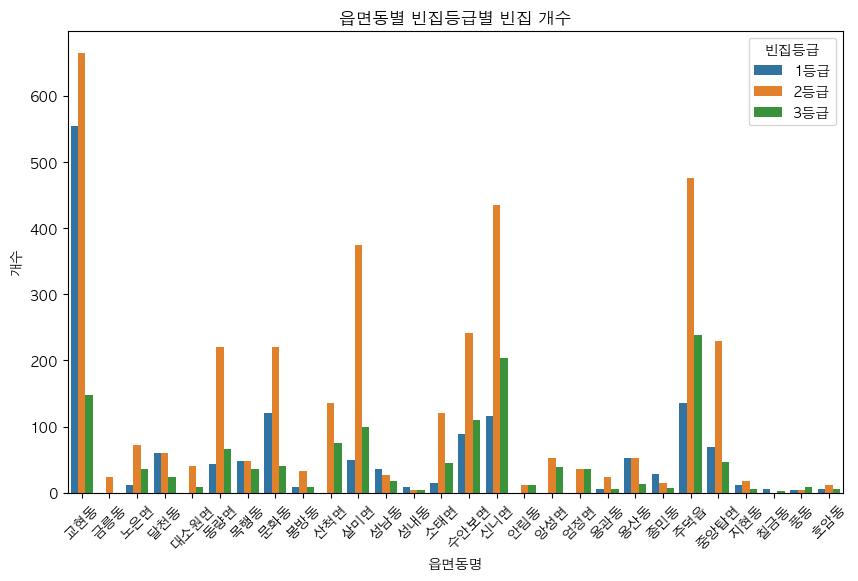

In [501]:
# 읍면동별 빈집등급별 빈집 개수 차트 시각화

df_grouped = df2.groupby(['읍면동명', '빈집등급'])['개수'].sum().reset_index()
valid_dongs = df_grouped.groupby('읍면동명')['개수'].sum()
valid_dongs = valid_dongs[valid_dongs > 6].index
df_filtered = df_grouped[df_grouped['읍면동명'].isin(valid_dongs)]

plt.figure(figsize=(10,6))
sns.barplot(data=df_filtered, x='읍면동명', y='개수', hue="빈집등급")

plt.title("읍면동별 빈집등급별 빈집 개수")
plt.xlabel("읍면동명")
plt.xticks(rotation=45)
plt.ylabel("개수")
plt.legend(title="빈집등급")
plt.show()

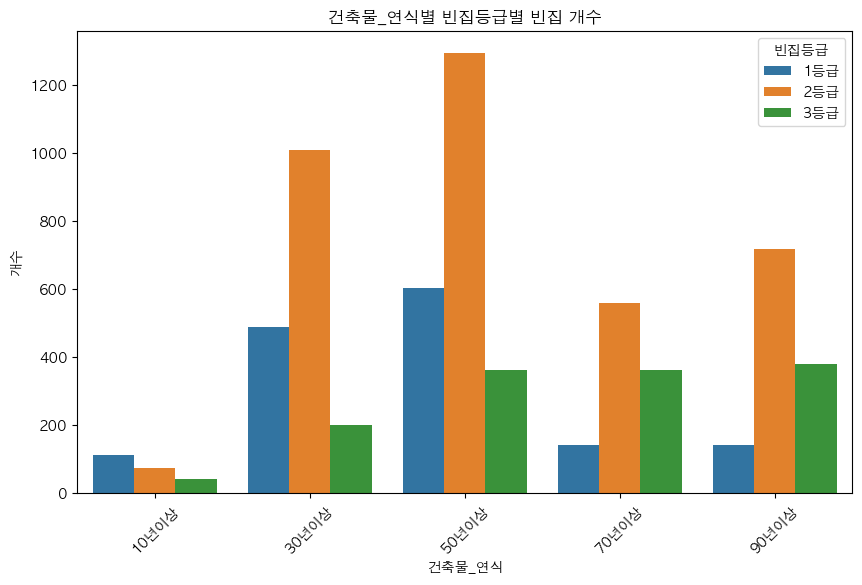

In [526]:
# 건축물_연식별 빈집등급별 빈집 개수 차트 시각화

df_grouped = df2.groupby(['건축물_연식', '빈집등급'])['개수'].sum().reset_index()
valid_dongs = df_grouped.groupby('건축물_연식')['개수'].sum()
valid_dongs = valid_dongs[valid_dongs > 6].index
df_filtered = df_grouped[df_grouped['건축물_연식'].isin(valid_dongs)]

plt.figure(figsize=(10,6))
sns.barplot(data=df_filtered, x='건축물_연식', y='개수', hue="빈집등급")

plt.title("건축물_연식별 빈집등급별 빈집 개수")
plt.xlabel("건축물_연식")
plt.xticks(rotation=45)
plt.ylabel("개수")
plt.legend(title="빈집등급")
plt.show()

### 3.2 최종 데이터 분석 결과도출

* 데이터 분석을 통해 얻은 새로운 지식, 인사이트를 정리하세요.
* 새로운 지식 및 인사이트 별 비지니스 전략을 도출할 수 있으면 정리해 보세요

## [ 지식 및 인사이트 ]

#### 0. 등급기준

+ 1등급은 관리, 보수 후 사용 가능한 수준이며, 4등급은 철거 수준의 빈집을 의미한다.

#### 1. 충주시 빈집 현황 인사이트 정리 (건축 연식별 빈집 분포)

+ 빈집의 분포에서 비슷한 연식의 빈집들이 주로 모여 있는 양상을 보인다.

+ 50년 이상 된 건물에서 빈집 비율이 가장 높으며, 10년 이상 건물에서는 빈집 비율이 가장 낮다.

#### 2. 지역별 주요 특징

+ 제1로터리 인근: 50년 이상 된 빈집(주황색 마커)이 밀집되어 있어 노후화가 두드러진다.

+ 산 근방(읍·리 단위 지역): 90년 이상 된 빈집(회색 마커)이 집중되어 있다.

+ 노은면·주덕읍: 90년 이상 된 빈집 및 구식 건물이 많아, 안전상 출입 제한 조치와 철거·정비가 필요하다.

+ 교현동: 과거 충주시 구도심 상권으로 인구가 많았으나, 서충주 신도시 개발로 인구 유출이 발생하여 현재 빈집이 가장 많다.

+ 연수동: 현 도심 상권이 위치한 곳으로 빈집이 전혀 없으며, 충주시 인구의 약 18.7%가 거주하는 핵심 생활권역으로 인프라 수준이 가장 우수하다.

#### 3. 빈집 분포에 영향을 주는 요인

+ 읍·면보다 동 단위 지역에 빈집이 더 많이 분포하는 경향이 있다. 이는 인구 밀도가 높은 지역일수록 빈집도 많아지는 현상과 관련된다.

+ 빈집 수가 많은 순서: 교현동 > 주덕읍 > 신니면

#### 4. 빈집 등급 분포

+ 전체 등급 중 2등급 빈집이 가장 많다.

+ 3등급은 연식이 증가할 수록, 증가하는 추세를 보이며, 반면 2등급은 50년까지는 증가하는 추세를 보이다가. 70년부터는 증가폭이 줄어든다.

+ 10년 이상 된 건물 중 일부는 1~2등급으로 관리만 하면 즉시 거주 또는 활용이 가능한 상태이다.

## [ 비즈니스 전략 ]

1. 빈집들이 밀집되어 있는 곳을 새로운 테마파크, 특화된 마을로 재개발하여 관광지로써 활용이 가능하다.
2. 산 근방은 빈집이 있어도 괜찮지만, 도심에 있는 90년 이상된 빈집들은 도시경관을 위해 정비가 필요하다.
3. '남한강'주변의 빈집이나, 그들을 활용한 건축물로 카페 및 관광지로 개발할 수 있다.
4. 산 근처의 빈집 들을 개발 할 시, 개발비용보다 철거비용이 더 크게 발생하지 않는지 고려가 필요하다.
5. 산 근처의 빈집들을 활용하여, 등산객들을 위한 쉼터 등으로 활용하는 것을 고려해본다.